# Signature detection from pretrained models

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection.retinanet import RetinaNet_ResNet50_FPN_Weights
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms.functional as TF
from torchvision import transforms
import webdataset as wds
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import json

In [2]:
# torch.cuda.is_available = lambda: False

# check GPU
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))

CUDA available: True
Device: NVIDIA GeForce MX450


### Hyperparameters

In [ ]:
train_dataset = "datasets/custom/train-00000.tar"
val_dataset = "datasets/custom/val-00000.tar"
test_dataset = "datasets/custom/test-00000.tar"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (signature) + background
imgsz = 512
epochs = 2
batch_size = 4
learning_rate = 0.005

### Dataset

In [30]:
transform = transforms.Compose([
    transforms.Resize((imgsz, imgsz)),
    transforms.ToTensor()
])

def preprocessSample(sample):
     # Detect image key dynamically
    img_key = None
    for k in sample.keys():
        if k.lower() in ["jpg", "jpeg", "png"]:
            img_key = k
            break
    if img_key is None:
        raise ValueError(f"No supported image format found in sample keys: {list(sample.keys())}")

    # Image already decoded to PIL
    img = sample[img_key]
    if img.mode != "RGB":
        img = img.convert("RGB")

    # Get original image size before resizing
    orig_w, orig_h = img.size

    # Resize image
    img_resized = transforms.Resize((imgsz, imgsz))(img)
    new_w, new_h = img_resized.size

    # Compute scale factors
    scale_x = new_w / orig_w
    scale_y = new_h / orig_h

    # Parse target
    target = sample["json"]

    # Convert boxes [x, y, w, h] → [x1, y1, x2, y2]
    boxes = []
    for (x, y, w, h) in target["boxes"]:
        x1, y1, x2, y2 = x, y, x + w, y + h
        # Scale coordinates
        x1 *= scale_x
        x2 *= scale_x
        y1 *= scale_y
        y2 *= scale_y
        boxes.append([x1, y1, x2, y2])

    # Convert to tensors
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64)

    # Final transform to tensor
    img_tensor = transforms.ToTensor()(img_resized)

    return img_tensor, target

In [49]:
train_dataset = (
    wds.WebDataset(train_dataset)   # <- use pattern or list of tar paths
    .decode("pil")
    .map(preprocessSample)
)
val_dataset = (
    wds.WebDataset(val_dataset)   # <- use pattern or list of tar paths
    .decode("pil")
    .map(preprocessSample)
)
test_dataset = (
    wds.WebDataset(test_dataset)   # <- use pattern or list of tar paths
    .decode("pil")
    .map(preprocessSample)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=0,
    collate_fn=lambda x: tuple(zip(*x))
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    num_workers=0, 
    collate_fn=lambda x: tuple(zip(*x))
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=0, 
    collate_fn=lambda x: tuple(zip(*x))
)

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\webdataset\compat.py:379: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


### utility functions

In [38]:
def iou(boxA, boxB):
    # boxes are [x1,y1,x2,y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = max(0, (boxA[2] - boxA[0])) * max(0, (boxA[3] - boxA[1]))
    boxBArea = max(0, (boxB[2] - boxB[0])) * max(0, (boxB[3] - boxB[1]))
    denom = float(boxAArea + boxBArea - interArea)
    return interArea / denom if denom > 0 else 0.0

In [39]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0
    it = 0
    for images, targets in loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
        it += 1
    return running_loss / max(1, it)

In [40]:
def validate(model, loader, device):
    model.train()
    val_loss = 0.0
    it = 0

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily run in train mode to get loss dict (model() in eval returns list)
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            it += 1

    return val_loss / max(1, it)


In [41]:
def evaluate_precision_recall(model, loader, device, iou_th=0.5, score_th=0.5):
    model.eval()
    TP = 0
    FP = 0
    FN = 0
    with torch.no_grad():
        for images, targets in loader:
            img = images[0].to(device)
            gt = targets[0]
            preds = model([img])[0]
            pred_boxes = preds['boxes'].cpu().numpy()
            pred_scores = preds['scores'].cpu().numpy()
            gt_boxes = gt['boxes'].cpu().numpy() if gt['boxes'].size(0) > 0 else np.zeros((0,4))

            keep_idx = np.where(pred_scores >= score_th)[0]
            pred_boxes = pred_boxes[keep_idx]
            matched_gt = set()
            for pb in pred_boxes:
                best_iou = 0
                best_j = -1
                for j, gb in enumerate(gt_boxes):
                    if j in matched_gt:
                        continue
                    cur_iou = iou(pb, gb)
                    if cur_iou > best_iou:
                        best_iou = cur_iou
                        best_j = j
                if best_iou >= iou_th and best_j >= 0:
                    TP += 1
                    matched_gt.add(best_j)
                else:
                    FP += 1
            FN += (len(gt_boxes) - len(matched_gt))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    return precision, recall


In [42]:
def training_loop(model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        t0 = time.time()
        try:
            train_loss = train_one_epoch(model, train_loader, optimizer, device)
            lr_scheduler.step()
            val_loss = validate(model, val_loader, device)
            prec, rec = evaluate_precision_recall(model, val_loader, device)
            print(f'Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, prec: {prec:.3f}, rec: {rec:.3f}, time: {time.time()-t0:.1f}s')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print('RuntimeError: CUDA out of memory during training.\nConsider:')
                # try to free cache and continue or abort
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                raise
            else:
                raise
    return model, train_losses, val_losses

## Training for different architectures

### Fast R-CNN - resnet

In [ ]:
frcnn_resnet_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
in_features = frcnn_resnet_model.roi_heads.box_predictor.cls_score.in_features
frcnn_resnet_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

try:
    frcnn_resnet_model.to(device)
except RuntimeError as e:
    print('Error moving model to device — falling back to CPU.\n', e)
    device = torch.device('cpu')
    frcnn_resnet_model.to(device)

# clear cache and reduce fragmentation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

params = [p for p in frcnn_resnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print("Starting training...")
frcnn_resnet_model, frcnn_resnet_train_losses, frcnn_resnet_val_losses \
    = training_loop(frcnn_resnet_model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs)

Starting training...


### Fast R-CNN - mobilenet

In [43]:
frcnn_mobilenet_model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=True)
in_features = frcnn_mobilenet_model.roi_heads.box_predictor.cls_score.in_features
frcnn_mobilenet_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

try:
    frcnn_mobilenet_model.to(device)
except RuntimeError as e:
    print('Error moving model to device — falling back to CPU.\n', e)
    device = torch.device('cpu')
    frcnn_mobilenet_model.to(device)

# clear cache and reduce fragmentation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

params = [p for p in frcnn_mobilenet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
print("Starting training...")
frcnn_mobilenet_model, frcnn_mobilenet_train_losses, frcnn_mobilenet_val_losses \
    = training_loop(frcnn_mobilenet_model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs)

Starting training...
Epoch 1/2 — train_loss: 0.5800, val_loss: 0.6576, prec: 0.833, rec: 0.312, time: 100.8s
Epoch 2/2 — train_loss: 0.6612, val_loss: 0.5571, prec: 0.727, rec: 0.500, time: 99.8s


### RetinaNet

In [ ]:
retinanet_model = torchvision.models.detection.retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
in_features = retinanet_model.head.classification_head.conv[0][0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = RetinaNetClassificationHead(in_features, num_anchors, 2)

try:
    retinanet_model.to(device)
except RuntimeError as e:
    print('Error moving model to device — falling back to CPU.\n', e)
    device = torch.device('cpu')
    retinanet_model.to(device)

# clear cache and reduce fragmentation
if torch.cuda.is_available():
    torch.cuda.empty_cache()

params = [p for p in retinanet_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [12]:
print("Starting training...")
retinanet_model, retinanet_train_losses, retinanet_val_losses \
    = training_loop(retinanet_model, train_loader, val_loader, optimizer, lr_scheduler, device, epochs)

Starting training...
Epoch 1/10 — train_loss: 1.6515, val_loss: 1.3018, prec: 0.000, rec: 0.000, time: 57.5s
Epoch 2/10 — train_loss: 1.6427, val_loss: 1.7344, prec: 0.000, rec: 0.000, time: 56.7s
Epoch 3/10 — train_loss: 1.5357, val_loss: 1.5019, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 4/10 — train_loss: 1.4325, val_loss: 1.4510, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 5/10 — train_loss: 1.3413, val_loss: 1.4351, prec: 0.000, rec: 0.000, time: 57.0s
Epoch 6/10 — train_loss: 1.2906, val_loss: 1.4355, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 7/10 — train_loss: 1.2551, val_loss: 1.4264, prec: 0.000, rec: 0.000, time: 57.0s
Epoch 8/10 — train_loss: 1.2435, val_loss: 1.4208, prec: 0.000, rec: 0.000, time: 56.9s
Epoch 9/10 — train_loss: 1.2356, val_loss: 1.4119, prec: 0.000, rec: 0.000, time: 57.0s
Epoch 10/10 — train_loss: 1.2290, val_loss: 1.4112, prec: 0.000, rec: 0.000, time: 57.0s


## Evaluation

In [45]:
model = frcnn_mobilenet_model
train_losses = frcnn_mobilenet_train_losses
val_losses = frcnn_mobilenet_val_losses

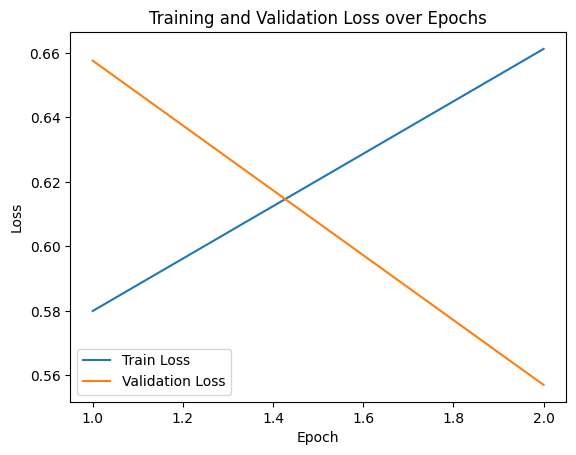

In [46]:
# plot training/validation loss curves
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [25]:
torch.save(model, './models/weights/retinanet_10e.pt')

## Inference

In [26]:
model = frcnn_mobilenet_model
model = torch.load('./models/weights/mobilenet_10e_augmented.pt', weights_only=False)

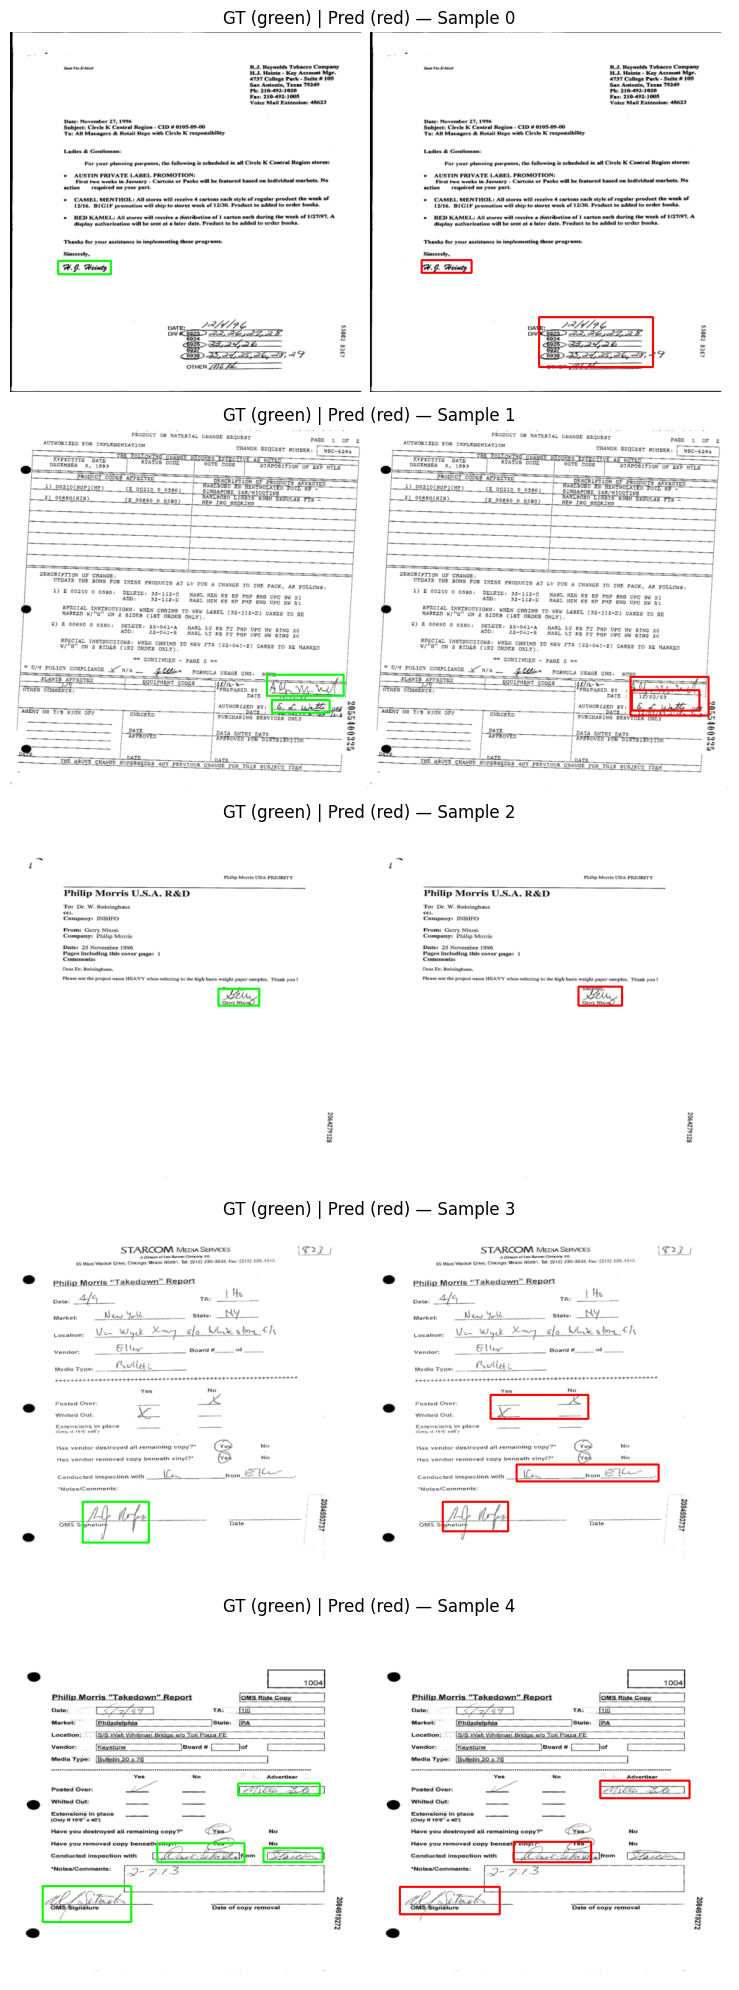

In [58]:
def draw_boxes(img_tensor, boxes, color=(0,255,0), linewidth=2):
    img = (img_tensor.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8).copy()
    for b in boxes:
        x1, y1, x2, y2 = map(int, b)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, linewidth)
    return img

n=5
score_thresh=0.5
model.eval()
plt.figure(figsize=(12, 4 * n))

cnt = 1
with torch.no_grad():
    iter_dataset = iter(test_dataset)
    for i in range(n):
        try:
            img_tensor, target = next(iter_dataset)
        except StopIteration:
            print("End of dataset reached.")
            break

        img = img_tensor.to(device)
        preds = model([img])[0]

        pred_boxes = preds['boxes'].cpu().numpy()
        pred_scores = preds['scores'].cpu().numpy()
        keep = pred_scores >= score_thresh
        pred_boxes = pred_boxes[keep]

        gt_boxes = (
            target['boxes'].numpy()
            if target["boxes"].numel() > 0
            else np.zeros((0, 4))
        )

        # Draw boxes: GT (green), Predictions (red)
        vis_gt = draw_boxes(img_tensor, gt_boxes, color=(0,255,0))
        vis_pred = draw_boxes(img_tensor, pred_boxes, color=(0,0,255))

        # Combine side-by-side
        combined = np.concatenate([vis_gt, vis_pred], axis=1)
        plt.subplot(n, 1, cnt)
        plt.axis("off")
        plt.title(f"GT (green) | Pred (red) — Sample {i}")
        plt.imshow(combined[:,:,::-1])
        cnt += 1

plt.tight_layout()
plt.show()

In [56]:
prec, rec = evaluate_precision_recall(model, test_loader, device)
print(f'Test Precision: {prec:.3f}, Test Recall: {rec:.3f}')

Test Precision: 0.923, Test Recall: 0.667
